                                           Recommendation System: Collaborative Filtering

## Librairies Import

In [5]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind

## Data Loading 

In [12]:
items=pd.read_csv(os.path.join('data','items.csv'))
users=pd.read_csv(os.path.join('data','user.csv'))
votes=pd.read_csv(os.path.join('data','votes.csv'))

MUI=votes.pivot(index='user.id',columns='item.id',values='rating').fillna(0)

## Data Analysis

**Overview of the data**

In [19]:
print("Overview of items : ")
display(items.head())
print()
print("Overview of users : ")
display(users.head())
print()
print("Overview of votes : ")
display(votes.head())

Overview of items : 


,movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0



Overview of users : 


,id,age,gender,job,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213



Overview of votes : 


,user.id,item.id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


**Number of users,items and rating**

In [22]:
print(f"Total Number of users : {users['id'].nunique()}")
print(f"Total Number of items : {items['movie.id'].nunique()}")
print(f"Total Number of votes : {len(votes)}")

Total Number of users : 943
Total Number of items : 1682
Total Number of votes : 100000


**Histogram of given ratings**

C:\Users\youss\AppData\Local\Temp\ipykernel_18596\1800264700.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sea.countplot(data=votes,x='rating',palette='viridis')


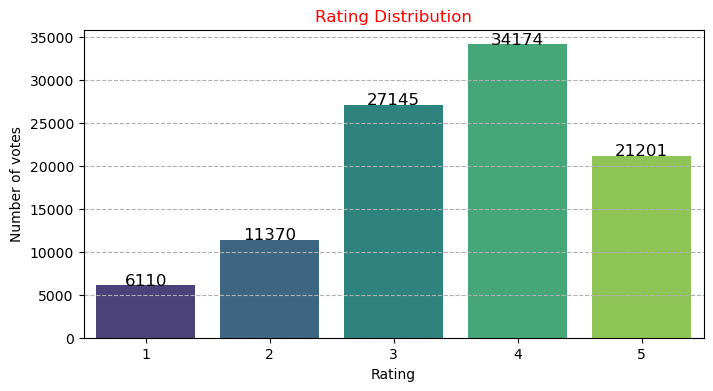

In [53]:
# Setting the size of the figure  (width=8 , height=4)
plt.figure(figsize=(8,4))
# creating a counplot to display the frequency of each rating value 
ax=sea.countplot(data=votes,x='rating',palette='viridis')
for p in ax.patches:
    height=p.get_height()
    width=p.get_width()
    x=p.get_x()
    ax.text(x=x+width/2,y=height+30,s=f"{int(height)}",fontsize=12,ha='center')

ax.set_xlabel("Rating")
ax.set_ylabel("Number of votes")
ax.set_title("Rating Distribution",c='r')
plt.grid(visible=True,axis='y',linestyle='--')

Analysis : 

- Asymetric distribution with a higher concentration on high ratings (rating 4 is the most frequent).
- Users tends to avoid giving low ratings which is a common pattern is recommendation systems where people are more likely to rate items when they enjoy.(Warning: Low scores are underrepresented which may lead to over-recommendation of highly rated items  and will likely require some form of score normalization.

Note : Rebalancing could be considered.Possible strategies include : 
- Normalizing rating per user
- Binarizing interactions
- Giving more weight to low rating during the optimisation process.


**Top10 Most Rated Items**

C:\Users\youss\AppData\Local\Temp\ipykernel_18596\4022581109.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sea.barplot(x=top10_items_votes,y=movies_name,palette='magma')


Text(0, 0.5, 'Items')

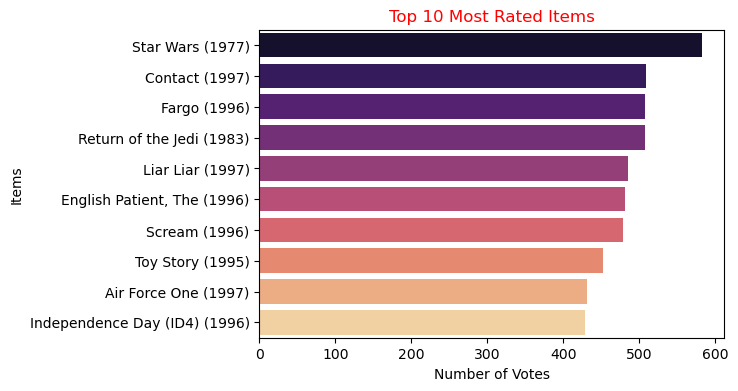

In [62]:
top10_items_votes=votes['item.id'].value_counts().head(10)
indexes=list(top10_items_votes.index) # Extracting the corresponding item-ids
movies_name=[items.loc[items['movie.id']==index,'movie.title'].iloc[0] for index in indexes] # Retrieving the movie titles associated with each item id
plt.figure(figsize=(6,4))
sea.barplot(x=top10_items_votes,y=movies_name,palette='magma')

plt.title('Top 10 Most Rated Items',c='r')
plt.xlabel('Number of Votes')
plt.ylabel('Items')



Analysis: 
Star Wars has the higher number of votes, suggesting that these movies may be over-recommended due to popularity bias. To mitigate this, it may become necessary to penalize popular items by reducing their influence in the recommendation process, for example, using TF-IDF weighting or amplification techniques. Using these adjustments is important for helping to preserve recommendation diversity and avoid reinforcing already dominant items. 

**Top 10 Most Actif Users**

C:\Users\youss\AppData\Local\Temp\ipykernel_18596\3944032690.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sea.barplot(x=top10_users_votes,y=indexes.astype(str),palette='cool')


Text(0, 0.5, 'Id User')

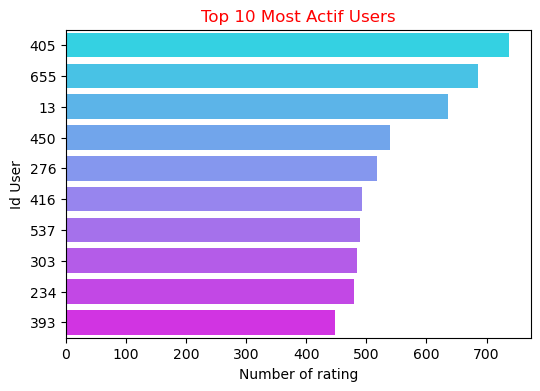

In [74]:
top10_users_votes=votes['user.id'].value_counts().head(10)
indexes=(top10_users_votes.index) # Extracting the corresponding user-ids
plt.figure(figsize=(6,4))
sea.barplot(x=top10_users_votes,y=indexes.astype(str),palette='cool')

plt.title('Top 10 Most Actif Users',c='r')
plt.xlabel('Number of rating')
plt.ylabel('Id User')



Analysis: 
The user with ID 405 has submitted over 700 ratings, significantly above average. Moreover, the top 10 users have rated at least 450 items , classifying them as power users or experts within the system. This also shows a user activity imbalance, where a small subset of users generates a large portion of interactions. These profiles may dominate the UI matrix and bias the model toward their specific preferences, potentially leading to overfitting.

Note: (We may use weighting mechanisms to reduce their disproportionate influence during model training).

**HeatMap MUI**

Text(95.72222222222221, 0.5, 'User Id')

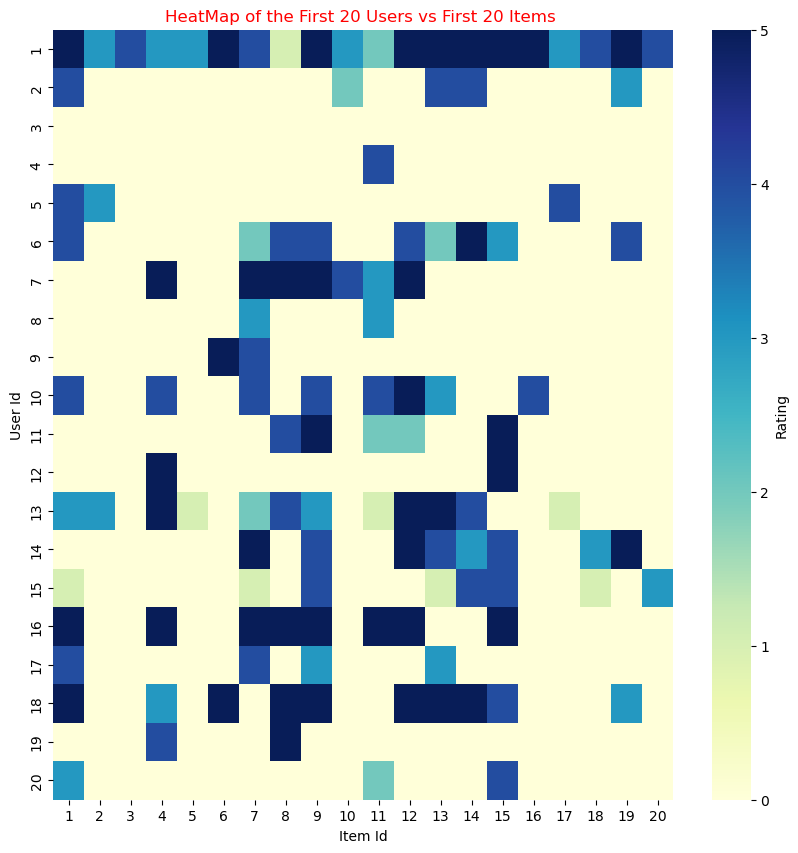

In [85]:
plt.figure(figsize=(10,10))
# Plotting a HeatMap of the first 20 users and 20 items from the MUI
sea.heatmap(data=MUI.iloc[:20,:20],cmap='YlGnBu',cbar_kws={'label':'Rating'})


plt.title("HeatMap of the First 20 Users vs First 20 Items ",c='r')
plt.xlabel('Item Id')
plt.ylabel('User Id')

Analysis: 

The UI matrix exhibits a high number of 0s, showing a common issue in recommendation systems: matrix sparsity. The sparsity arises because users typically rate only a small fraction of available items, introducing challenges in computing similarities and reducing the robustness of predictions.

To address this, it might be beneficial to apply matrix factorization techniques such as SVD, NMF, ALS, or gradient-based factorization methods, which are well suited for handling sparse interaction data.

## Simple Baseline Methods